TAREA: Los ejemplos ilustrativos anteriores permiten saber el número de monedas presentes en la imagen. ¿Cómo saber la cantidad de dinero presente en ella? Sugerimos identificar de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras obtener esa información y las dimensiones en milímetros de las distintas monedas, realiza una propuesta para estimar la cantidad de dinero en la imagen. Muestra la cuenta de monedas y dinero sobre la imagen. No hay restricciones sobre utilizar medidas geométricas o de color. 

Una vez resuelto el reto con la imagen ideal proporcionada, captura una o varias imágenes con monedas. Aplica el mismo esquema, tras identificar la moneda del valor determinado, calcula el dinero presente en la imagen. ¿Funciona correctamente? ¿Se observan problemas?

Nota: Para establecer la correspondencia entre píxeles y milímetros, comentar que la moneda de un euro tiene un diámetro de 23.25 mm. la de 50 céntimos de 24.35, la de 20 céntimos de 22.25, etc. 

Extras: Considerar que la imagen pueda contener objetos que no son monedas y/o haya solape entre las monedas. Demo en vivo. 



Monedas encontradas y filtradas: 8


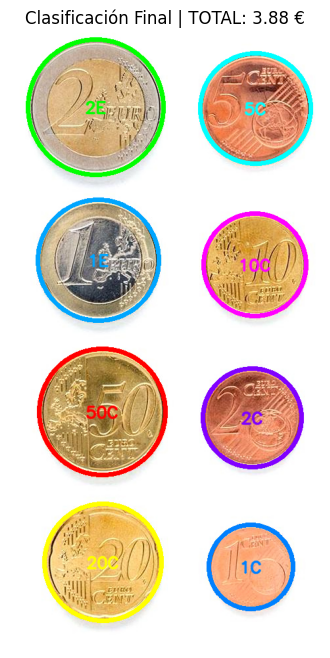

Monedas encontradas y filtradas: 8


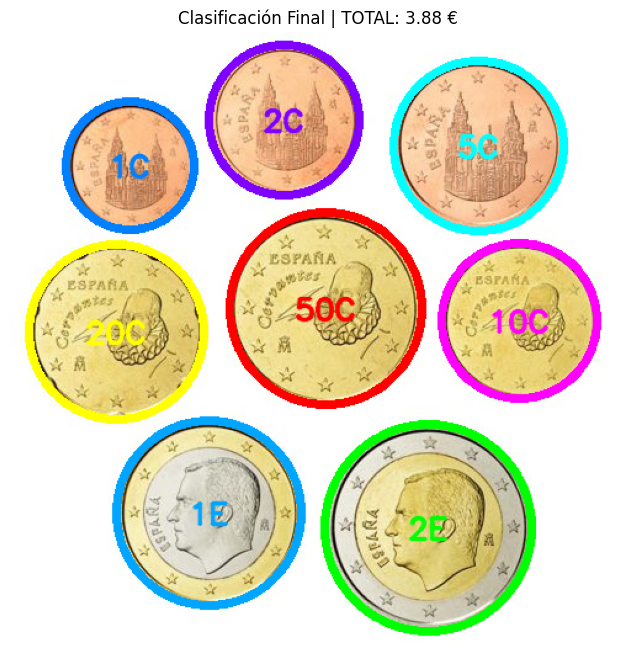

Monedas encontradas y filtradas: 7


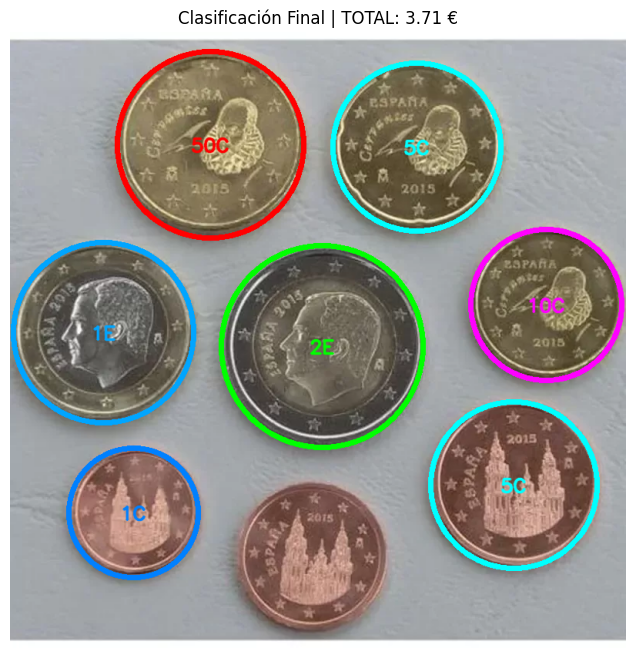

Monedas encontradas y filtradas: 12


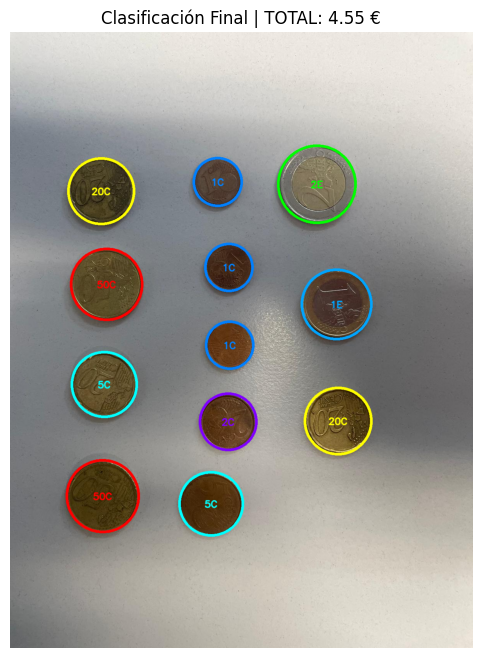

Monedas encontradas y filtradas: 11


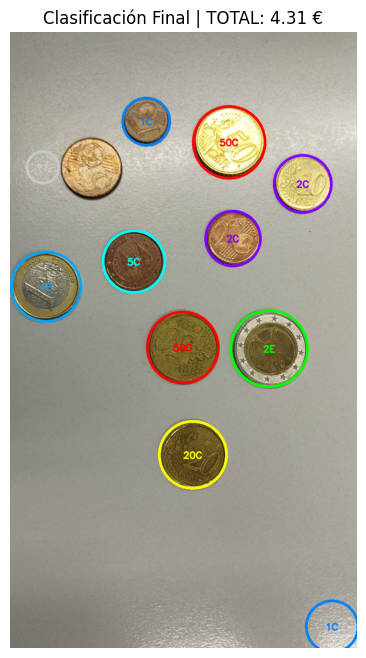

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- CONFIGURACIÓN GLOBAL DE MONEDAS ---
# Diccionarios con las propiedades de cada tipo de moneda de euro.
MONEDAS_MM = {
    "2E": 25.75, "50C": 24.25, "1E": 23.25, "20C": 22.25,
    "5C": 21.25, "10C": 19.75, "2C": 18.75, "1C": 16.25,
}
VALORES_EUR = {
    "2E": 2.00, "1E": 1.00, "50C": 0.50, "20C": 0.20,
    "10C": 0.10, "5C": 0.05, "2C": 0.02, "1C": 0.01
}
COLORES = { # Colores RGB para dibujar cada tipo de moneda
    "2E": (0, 255, 0), "1E": (0, 165, 255), "50C": (255, 0, 0),
    "20C": (255, 255, 0), "10C": (255, 0, 255),
    "5C": (0, 255, 255), "2C": (128, 0, 255),
    "1C": (0, 128, 255), "??": (200, 200, 200)
}

# --- FUNCIÓN PRINCIPAL DE ANÁLISIS DE MONEDAS ---
def analizar_monedas(ruta_imagen: str):
    # --- CARGA Y PREPROCESO DE LA IMAGEN ---
    img = cv2.imread(ruta_imagen)
    if img is None:
        print(f"Error: No se pudo cargar la imagen en la ruta '{ruta_imagen}'.")
        return

    img_rgb_original = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    suavizado = cv2.GaussianBlur(img_gris, (9, 9), 2)

    # --- SEGMENTACIÓN Y LIMPIEZA DE MÁSCARA ---
    mascara = cv2.adaptiveThreshold(suavizado, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                    cv2.THRESH_BINARY_INV, 11, 2)
    kernel = np.ones((3, 3), np.uint8)
    mascara_limpia = cv2.morphologyEx(mascara, cv2.MORPH_CLOSE, kernel, iterations=3)

    # --- DETECCIÓN Y FILTRADO DE ELIPSES ---
    contornos, _ = cv2.findContours(mascara_limpia, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    elipses_buenas = []
    for c in contornos:
        # Filtrar contornos pequeños o con pocos puntos para evitar errores
        if cv2.contourArea(c) < 500 or len(c) < 5:
            continue
        try:
            elipse = cv2.fitEllipse(c)
            (centro, ejes, angulo) = elipse
            (eje_menor, eje_mayor) = ejes
            # Filtrar formas que no sean circulares (aspect_ratio cercano a 1)
            aspect_ratio = eje_mayor / eje_menor if eje_menor > 0 else 0
            if aspect_ratio < 1.4:
                elipses_buenas.append(elipse)
        except cv2.error:
            # Ignorar contornos que no pueden ajustarse a una elipse
            continue
    
    if not elipses_buenas:
        print("No se encontraron formas de moneda válidas en la imagen.")
        return

    # --- 5. CLASIFICACIÓN Y CONTEO ---
    img_clasificada = img_rgb_original.copy()
    conteo, total = {}, 0.0

    # Crear una lista de candidatos a moneda con su centro y radio promedio
    cands = [((int(c[0][0]), int(c[0][1])), (c[1][0] + c[1][1]) / 4.0) for c in elipses_buenas]
    # Ordenar de mayor a menor radio para calibrar con la más grande
    cands.sort(key=lambda t: t[1], reverse=True)

    # Calibración: Asumir que la moneda más grande es de 2 Euros
    radio_moneda_grande_px = cands[0][1]
    escala = MONEDAS_MM["2E"] / (2.0 * radio_moneda_grande_px)

    # Preparar arrays para comparación rápida
    tipos_ref = np.array(list(MONEDAS_MM.keys()))
    diametros_ref = np.array(list(MONEDAS_MM.values()))

    # Clasificar cada candidato
    for (x, y), r in cands:
        d_mm = (2.0 * r) * escala  # Diámetro en milímetros
        diferencias = np.abs(d_mm - diametros_ref)
        idx_mejor = np.argmin(diferencias)
        
        tipo = "??"
        # Asignar tipo solo si la diferencia es menor a un umbral (1.5mm)
        if diferencias[idx_mejor] < 1.5:
            tipo = tipos_ref[idx_mejor]
            conteo[tipo] = conteo.get(tipo, 0) + 1
            total += VALORES_EUR[tipo]
        
        # Dibujar la elipse y el texto sobre la imagen
        color = COLORES.get(tipo, COLORES["??"])
        cv2.ellipse(img_clasificada, (x, y), (int(r), int(r)), 0, 0, 360, color, 5)
        
        texto_mostrar = f"{tipo}"
        (ancho_texto, alto_texto), _ = cv2.getTextSize(texto_mostrar, cv2.FONT_HERSHEY_SIMPLEX, 0.8, 2)
        pos_texto = (x - ancho_texto // 2, y + alto_texto // 2)
        cv2.putText(img_clasificada, texto_mostrar, pos_texto, cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, cv2.LINE_AA)

    print(f"Monedas encontradas y filtradas: {len(cands)}")

    # --- 6. VISUALIZACIÓN Y RESUMEN ---
    plt.figure(figsize=(12, 8))
    plt.title(f'Clasificación Final | TOTAL: {total:.2f} €')
    plt.axis("off")
    plt.imshow(img_clasificada)
    plt.show()


# --- EJEMPLO DE USO DE LA FUNCIÓN ---
analizar_monedas("Monedas/Monedas.jpg")
analizar_monedas("Monedas/Monedas2.jpg")
analizar_monedas("Monedas/Monedas.webp")
analizar_monedas("Monedas/Monedas.jfif")
analizar_monedas("Monedas/Monedas2.jfif")

TAREA: La tarea consiste en extraer características (geométricas y/o visuales) de las tres imágenes completas de partida, y *aprender* patrones que permitan identificar las partículas en nuevas imágenes. Para ello se proporciona como imagen de test *MPs_test.jpg* y sus correpondientes anotaciones *MPs_test_bbs.csv* con la que deben obtener las métricas para su propuesta de clasificación de microplásticos, además de la matriz de confusión. La matriz de confusión permitirá mostrar para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente como perteneciente a una de las otras dos clases.

En el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación entre el cuadrado del perímetro y el área de la partícula)
- Relación del área de la partícula con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

Si no se quedan satisfechos con la segmentación obtenida, es el mundo real, también en el README comento técnicas recientes de segmentación, que podrían despertar su curiosidad.

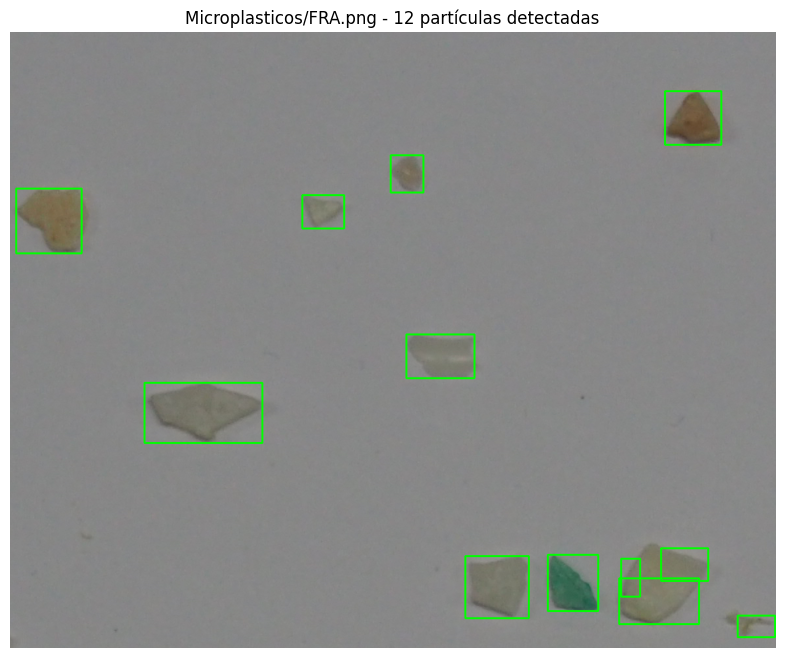

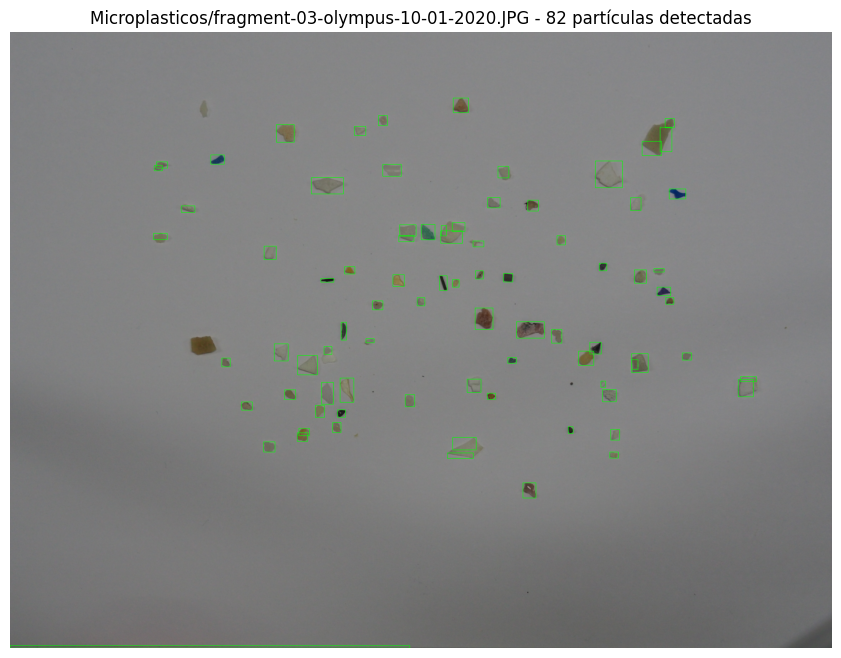

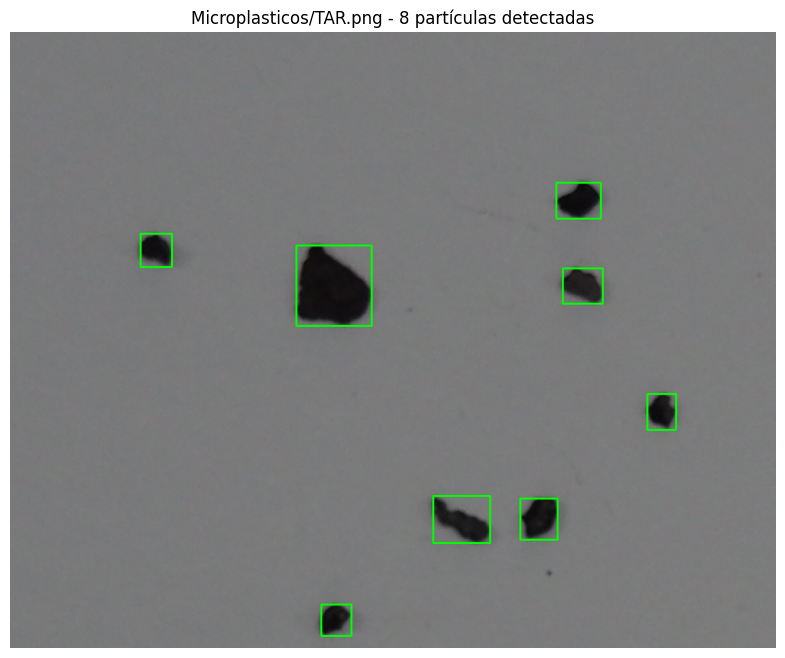

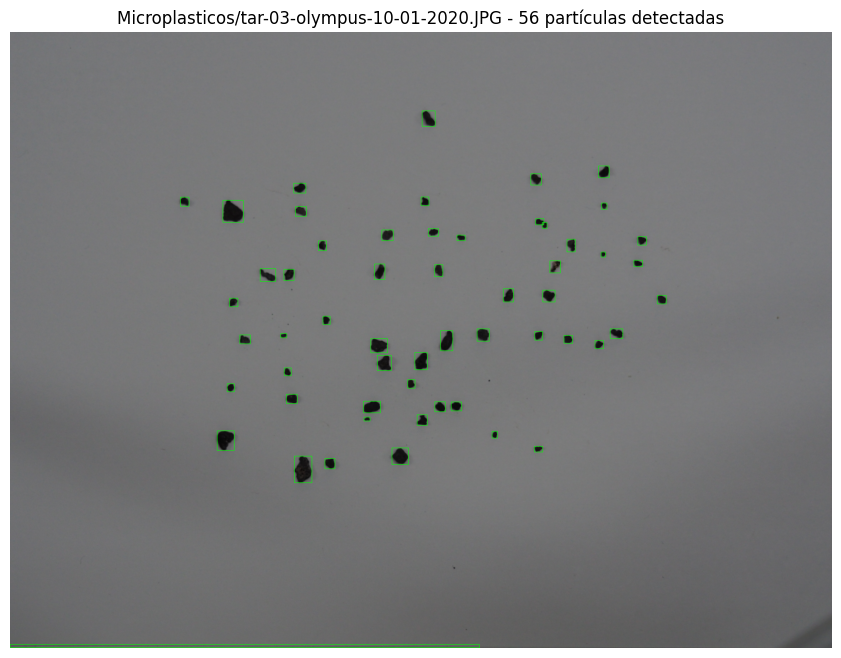

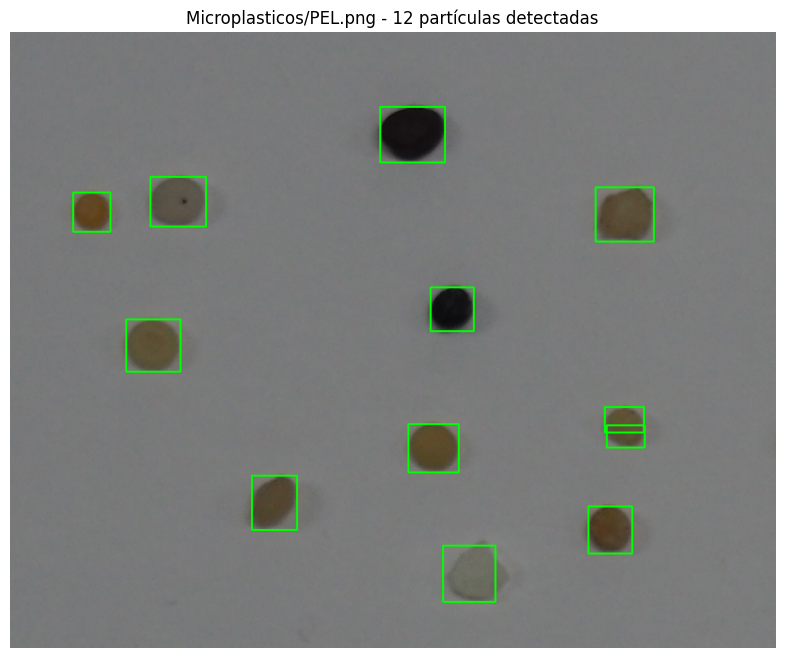

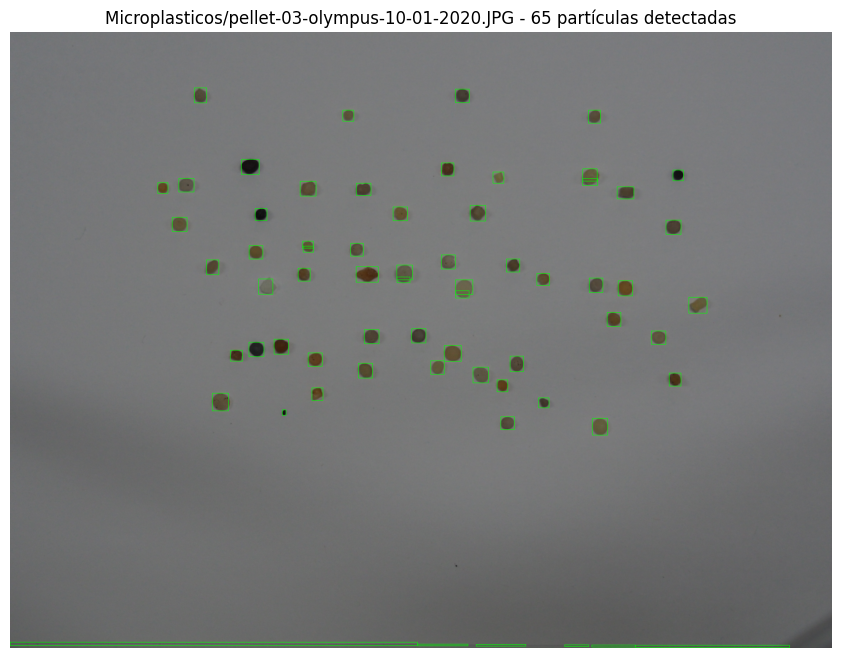

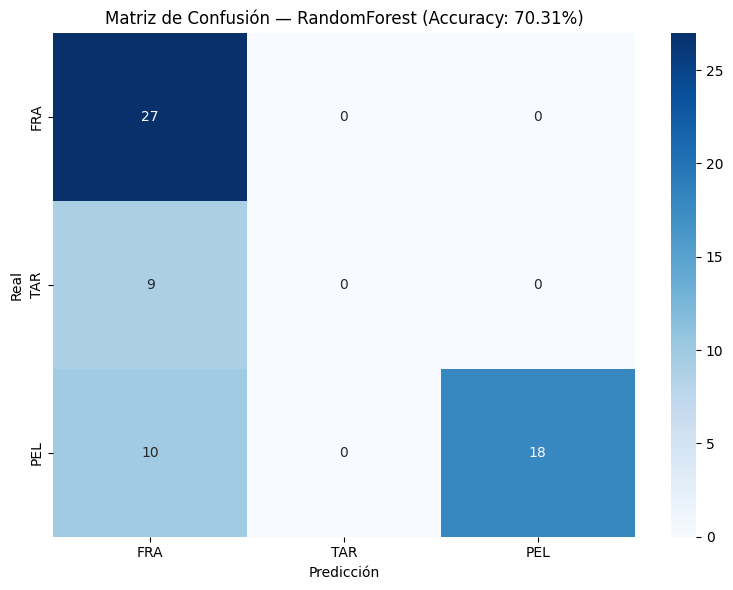

Accuracy: 0.7031


In [2]:
# --- Imports ---
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

# --- Utilidades básicas ---

# Cálculo del solapamiento entre dos rectángulos
def calcular_solapamiento_contornos(r1: tuple, r2: tuple) -> float:
    x1, y1, w1, h1 = r1
    x2, y2, w2, h2 = r2
    xa = max(x1, x2)
    ya = max(y1, y2)
    xb = min(x1 + w1, x2 + w2)
    yb = min(y1 + h1, y2 + h2)
    inter_w = max(0, xb - xa)
    inter_h = max(0, yb - ya)
    inter_area = inter_w * inter_h
    area1 = w1 * h1
    area2 = w2 * h2
    union = area1 + area2 - inter_area
    return inter_area / union if union > 0 else 0.0

# --- Detección de contornos válidos ---
def detectar_contornos_validos(img, min_area=300, max_area=10000, umbral_solapamiento=0.5):
    # Aplica preprocesado, segmentación y encuentra contornos
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    background = cv2.medianBlur(gray, 31)
    gray_corrected = cv2.addWeighted(gray, 1.5, background, -0.5, 0)
    mask = cv2.adaptiveThreshold(
        cv2.GaussianBlur(gray_corrected, (5, 5), 0), 255,
        cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 2
    )
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = [c for c in contours if min_area <= cv2.contourArea(c) <= max_area]

    # Suprimir contornos solapados
    to_remove = set()
    for i in range(len(contours)):
        if i in to_remove:
            continue
        ri = cv2.boundingRect(contours[i])
        ai = cv2.contourArea(contours[i])
        for j in range(i + 1, len(contours)):
            if j in to_remove:
                continue
            rj = cv2.boundingRect(contours[j])
            aj = cv2.contourArea(contours[j])
            if calcular_solapamiento_contornos(ri, rj) > umbral_solapamiento:
                if ai < aj:
                    to_remove.add(i)
                    break
                else:
                    to_remove.add(j)
    return [c for k, c in enumerate(contours) if k not in to_remove]


# --- Extracción de características de contornos ---
def extraer_características_contornos(img, contours):
    # Para cada contorno calcula 8 características + devuelve su bounding box:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    features, rects = [], []
    for c in contours:
        area = cv2.contourArea(c) # Area
        if area == 0: 
            continue

        perimetro = cv2.arcLength(c, True) # Perímetro
        x, y, w, h = cv2.boundingRect(c) # Bounding Box
        rel_aspecto = w / h if h else 0.0 # Ratio ancho/alto
        rel_area_cont = area / (w * h) if w * h else 0.0 # Área relativa dentro del bbox
        compact = (perimetro ** 2) / (4 * np.pi * area) # Compacidad

        # Calcular relación de ejes de elipse (si es posible ajustarla)
        rel_ejes = 0.0
        if len(c) >= 5:
            try:
                (_, _), (MA, ma), _ = cv2.fitEllipse(c)
                rel_ejes = (ma / MA) if MA else 0.0
            except Exception:
                rel_ejes = 0.0

        # Centroide + dispersión radial normalizada (min/max)
            M = cv2.moments(c) # Centroide
            cx, cy = (int(M["m10"]/M["m00"]), int(M["m01"]/M["m00"])) if M["m00"] else (0, 0) # Cálculo del centro del contorno 
            dists = [np.linalg.norm(np.array([cx, cy]) - pt[0]) for pt in c] # Distancias al centro
            rel_dist_centroid = (min(dists) / max(dists)) if dists and max(dists) != 0 else 0.0 # Dispersión radial normalizada

        # Color medio del objeto: distancia al negro
        mask_obj = np.zeros(gray.shape, np.uint8) # Máscara del objeto
        cv2.drawContours(mask_obj, [c], -1, 255, -1) # Rellenar el contorno
        mean_color = cv2.mean(img, mask=mask_obj)[:3] # Color medio BGR
        black_dist = float(np.linalg.norm(np.array(mean_color))) # Distancia al negro  

        # Calcular clips para estabilizar outliers en ratios
        rel_aspecto = float(np.clip(rel_aspecto, 0, 10))
        rel_ejes = float(np.clip(rel_ejes, 0, 10))

        # Añadir características y bounding box
        features.append([
            float(area), float(perimetro), float(compact), float(rel_area_cont),
            rel_aspecto, rel_ejes, float(rel_dist_centroid), black_dist
        ])
        rects.append((x, y, w, h))
    return np.array(features), rects


# --- Procesamiento de imagen para extracción de características ---
def extraer_caracteristicas(ruta_imagen, min_area_contorno=300, max_area_contorno=10000,
                            umbral_solapamiento=0.3, visualizar=False):

    # Cargar imagen
    imagen = cv2.imread(ruta_imagen)
    if imagen is None:
        raise FileNotFoundError(f"No se pudo leer la imagen: {ruta_imagen}")

    # Detección de contornos
    contornos = detectar_contornos_validos(
        imagen, min_area=min_area_contorno, max_area=max_area_contorno, umbral_solapamiento=umbral_solapamiento
    )
    features_array, rects = extraer_características_contornos(imagen, contornos)

    # Filtrado por área mínima y creación de lista de partículas
    particulas, rects_validos = [], []
    for i, feat in enumerate(features_array):
        if feat[0] < min_area_contorno:
            continue
        particulas.append({
            "features": {
                "area": feat[0], "perimetro": feat[1], "compacidad": feat[2], "rel_area_cont": feat[3],
                "aspect_ratio": feat[4], "rel_ejes": feat[5], "rel_dist_centroid": feat[6], "black_dist": feat[7]
            },
            "cx": rects[i][0] + rects[i][2] // 2,
            "cy": rects[i][1] + rects[i][3] // 2
        })
        rects_validos.append(rects[i])

    # Visualización opcional: imagen segmentada con cajas
    if visualizar and len(particulas) > 0:
        img_visual = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
        for (x, y, w, h) in rects_validos:
            cv2.rectangle(img_visual, (x, y), (x + w, y + h), (0, 255, 0), 2)
        plt.figure(figsize=(12, 8))
        plt.imshow(img_visual)
        plt.title(f'{ruta_imagen} - {len(particulas)} partículas detectadas')
        plt.axis('off')
        plt.show()

    return particulas


# --- Construcción del dataset de entrenamiento ---
# Generar diccionario con imágenes de entrenamiento por clase
imagenes_entrenamiento = {
    0: ["Microplasticos/FRA.png", "Microplasticos/fragment-03-olympus-10-01-2020.JPG"],  # Fragmentos
    1: ["Microplasticos/TAR.png", "Microplasticos/tar-03-olympus-10-01-2020.JPG"],       # Alquitrán
    2: ["Microplasticos/PEL.png", "Microplasticos/pellet-03-olympus-10-01-2020.JPG"]     # Pellets
}

# Parámetros de detección y extracción
MIN_AREA_CONTORNO_TRAIN = 300
MAX_AREA_CONTORNO_TRAIN = 10000
IOU_THRESHOLD = 0.3

# Extraer características de todas las imágenes de entrenamiento
X_train, y_train = [], []
for clase_id, imagenes in imagenes_entrenamiento.items():
    for ruta in imagenes:
        parts = extraer_caracteristicas(
            ruta,
            min_area_contorno=MIN_AREA_CONTORNO_TRAIN,
            max_area_contorno=MAX_AREA_CONTORNO_TRAIN,
            umbral_solapamiento=IOU_THRESHOLD,
            visualizar=True   # ← muestra las imágenes segmentadas de entrenamiento
        )
        for p in parts:
            X_train.append(p["features"])
            y_train.append(clase_id)

df_X = pd.DataFrame(X_train)


# --- Entrenamiento del modelo de clasificación ---
modelo = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced_subsample",
    random_state=42
)
modelo.fit(df_X, y_train)


# --- Detección y clasificación en test (imagen completa) ---

# Se detecta en toda la imagen (mismo procesamiento que el entrenamiento)
# Leer CSV de anotaciones y transformar etiquetas a IDs
df_test = pd.read_csv("Microplasticos/MPs_test_bbs.csv")
mapa_clases = {"FRA": 0, "TAR": 1, "PEL": 2}
df_test["class_id"] = df_test["label"].map(mapa_clases) # Mapear etiquetas a IDs

# Leer imagen de test
imagen_test = cv2.imread("Microplasticos/MPs_test.jpg")
if imagen_test is None:
    raise FileNotFoundError("No se pudo leer la imagen de test: MPs_test.jpg")

# Detección de contornos y extracción de características
cont_test = detectar_contornos_validos(
    imagen_test,
    min_area=MIN_AREA_CONTORNO_TRAIN,
    max_area=MAX_AREA_CONTORNO_TRAIN * 5,
    umbral_solapamiento=IOU_THRESHOLD
)
feat_test, rects_test = extraer_características_contornos(imagen_test, cont_test)

# Clasificación de cada partícula detectada
preds_detectadas = []
for feat in feat_test:
    Xd = pd.DataFrame([dict(zip(df_X.columns, feat))])[df_X.columns]
    preds_detectadas.append(modelo.predict(Xd)[0])


# --- Comparación de predicción vs anotaciones reales ---
# Transformar bounding boxes anotadas a formato (x, y, w, h)
def row_to_rect(row):
    if {"x_min", "y_min", "x_max", "y_max"}.issubset(row.index):
        x_min, y_min, x_max, y_max = int(row["x_min"]), int(row["y_min"]), int(row["x_max"]), int(row["y_max"])
        return (x_min, y_min, x_max - x_min, y_max - y_min)
    elif {"x", "y", "w", "h"}.issubset(row.index):
        return (int(row["x"]), int(row["y"]), int(row["w"]), int(row["h"]))
    return None

# Para cada anotación, buscar la detección con mayor solapamiento y comparar etiquetas
UMBRAL_DE_SOLAPAMIENTO = 0.30
y_true, y_pred_match = [], []
for _, row in df_test.iterrows():
    gt_rect = row_to_rect(row)
    if gt_rect is None:
        continue
    best_overlap, best_idx = 0.0, -1
    for i, det_rect in enumerate(rects_test):
        iou = calcular_solapamiento_contornos(gt_rect, det_rect)
        if iou > best_overlap:
            best_overlap, best_idx = iou, i
    if best_overlap >= UMBRAL_DE_SOLAPAMIENTO and best_idx >= 0:
        y_true.append(row["class_id"])
        y_pred_match.append(preds_detectadas[best_idx])


# --- visualización de resultados ---
if len(y_true) > 0:
    accuracy = accuracy_score(y_true, y_pred_match)
    cm = confusion_matrix(y_true, y_pred_match, labels=[0, 1, 2])

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["FRA", "TAR", "PEL"],
                yticklabels=["FRA", "TAR", "PEL"])
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title(f"Matriz de Confusión — RandomForest (Accuracy: {accuracy:.2%})")
    plt.tight_layout()
    plt.show()

    print(f"Accuracy: {accuracy:.4f}")


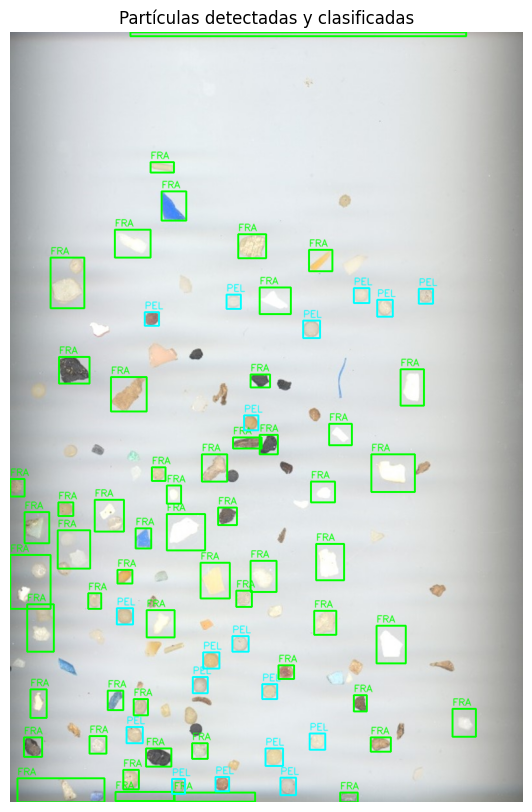

In [3]:
# --- Visualización de partículas detectadas ---

# Colores por clase (FRA, TAR, PEL)
color_map = {
    0: (0, 255, 0),    # Verde -> FRA
    1: (0, 0, 255),    # Rojo  -> TAR
    2: (255, 255, 0)   # Amarillo -> PEL
}

# Copia de la imagen original
img_vis = imagen_test.copy()

# Dibuja cada rectángulo
for i, (x, y, w, h) in enumerate(rects_test):
    pred = preds_detectadas[i]
    if pred is None:
        continue
    color = color_map.get(pred, (255, 255, 255))
    cv2.rectangle(img_vis, (x, y), (x + w, y + h), color, 2)
    cv2.putText(img_vis, ["FRA", "TAR", "PEL"][pred],
                (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)

# Mostrar resultado
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
plt.title("Partículas detectadas y clasificadas")
plt.axis("off")
plt.show()
